# Installation

In [ ]:
!pip install ultralytics --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 98.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 70.5 MB/s eta 0:00:00


# Vérification avant de commencer

In [ ]:
import ultralytics

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
ultralytics.checks()

Ultralytics 8.3.134 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 41.9/112.6 GB disk)


Visualisation des ressources et utilisation GPU

In [ ]:
!nvidia-smi

Thu May 15 09:54:33 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   40C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Vérification disponibilité GPU

In [ ]:
import torch
print("GPU disponible :", torch.cuda.is_available())

GPU disponible : True


# Préparation du dataset

In [ ]:
!unzip -q /content/data.zip -d /content/custom_data_raw

## Organisation à avoir

```
custom_data/
├── images/
│   ├── train/
│   └── val/
├── labels/
│   ├── train/
│   └── val/


## Réorganisation du dataset

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Répertoire d'origine pour les images et annotations
raw_data_path_images = "/content/custom_data_raw/images"  # Images sont dans ce dossier
raw_data_path_labels = "/content/custom_data_raw/obj_train_data"  # Annotations dans ce dossier

# Obtenir toutes les images (jpg/png) présentes dans le dossier "images"
images = [f for f in os.listdir(raw_data_path_images) if f.endswith(('.jpg', '.png'))]

# Split train/val (80% train, 20% val)
train_imgs, val_imgs = train_test_split(images, test_size=0.2, random_state=42)

# Création des dossiers cible pour images et labels
base_path = "/content/custom_data"


os.makedirs(base_path + "/images/train", exist_ok=True)
os.makedirs(base_path + "/images/val", exist_ok=True)
os.makedirs(base_path + "/labels/train", exist_ok=True)
os.makedirs(base_path + "/labels/val", exist_ok=True)

def move_data(image_list, split):
    for img_name in image_list:
        # Déplacer l'image vers le bon dossier
        src_img = os.path.join(raw_data_path_images, img_name)
        dst_img = os.path.join(base_path, f"images/{split}", img_name)
        shutil.copy(src_img, dst_img)

        # Vérifier et déplacer l'annotation .txt correspondante
        txt_name = img_name.rsplit('.', 1)[0] + '.txt'
        txt_src = os.path.join(raw_data_path_labels, txt_name)
        txt_dst = os.path.join(base_path, f"labels/{split}", txt_name)

        if os.path.exists(txt_src):
            shutil.copy(txt_src, txt_dst)
        else:
            print(f"Pas d'annotation pour {img_name}")

# Appliquer le déplacement aux deux splits : train et val
move_data(train_imgs, "train")
move_data(val_imgs, "val")


# Augmentation


In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import cv2
import os

# === PARAMÈTRES ===
augmentations = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2),
    A.RandomBrightnessContrast(p=0.3),
    A.Rotate(limit=20, p=0.3),
    A.RandomGamma(p=0.3),
    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.4)
])

# Tu appliques l'augmentation uniquement sur le dossier d'entraînement
augmented_path = "/content/custom_data_augmented/images/train"
augmented_label_path = "/content/custom_data_augmented/labels/train"
os.makedirs(augmented_path, exist_ok=True)
os.makedirs(augmented_label_path, exist_ok=True)

original_train_images_path = "/content/custom_data/images/train"
original_train_labels_path = "/content/custom_data/labels/train"

# Copie les fichiers originaux
for img_file in tqdm(os.listdir(original_train_images_path), desc="Copie des images originales"):
    if not img_file.endswith(('.jpg', '.png')):
        continue
    img_path = os.path.join(original_train_images_path, img_file)
    label_path = os.path.join(original_train_labels_path, img_file.replace('.jpg', '.txt').replace('.png', '.txt'))

    img = cv2.imread(img_path)
    h, w = img.shape[:2]

    # Sauvegarde originale
    cv2.imwrite(os.path.join(augmented_path, img_file), img)
    shutil.copy(label_path, os.path.join(augmented_label_path, os.path.basename(label_path)))

    # Augmente 2 fois chaque image
    for i in range(2):
        augmented = augmentations(image=img)["image"]
        aug_img_name = img_file.replace('.', f'_aug{i}.')
        aug_lbl_name = img_file.replace('.jpg', f'_aug{i}.txt').replace('.png', f'_aug{i}.txt')

        cv2.imwrite(os.path.join(augmented_path, aug_img_name), augmented)
        shutil.copy(label_path, os.path.join(augmented_label_path, aug_lbl_name))

print("✅ Dataset augmenté.")


Copie des images originales: 100%|██████████| 36/36 [00:19<00:00,  1.87it/s]

✅ Dataset augmenté.


In [ ]:
# Copie val original sans modification
original_val_images_path = "/content/custom_data/images/val"
original_val_labels_path = "/content/custom_data/labels/val"

val_img_out_dir = "/content/custom_data_augmented/images/val"
val_lbl_out_dir = "/content/custom_data_augmented/labels/val"

os.makedirs(val_img_out_dir, exist_ok=True)
os.makedirs(val_lbl_out_dir, exist_ok=True)

for img_file in os.listdir(original_val_images_path):
    if not img_file.endswith(('.jpg', '.png')):
        continue

    img_src = os.path.join(original_val_images_path, img_file)
    lbl_src = os.path.join(original_val_labels_path, img_file.replace('.jpg', '.txt').replace('.png', '.txt'))

    img_dst = os.path.join(val_img_out_dir, img_file)
    lbl_dst = os.path.join(val_lbl_out_dir, os.path.basename(lbl_src))

    shutil.copy(img_src, img_dst)
    shutil.copy(lbl_src, lbl_dst)

print("✅ Validation copiée sans modification.")


✅ Validation copiée sans modification.


# Split des images du dataset

In [ ]:
import os
import cv2
import shutil

# === PARAMÈTRES ===
# input_root = "/content/custom_data"
input_root = "/content/custom_data_augmented"

output_root = "/content/split_custom_data"

base_split_path = "/content/split_custom_data"

tile_size = 640
overlap = 0

splits = ["train", "val"]

def yolo_to_bbox(x_center, y_center, w, h, img_w, img_h):
    x1 = int((x_center - w / 2) * img_w)
    y1 = int((y_center - h / 2) * img_h)
    x2 = int((x_center + w / 2) * img_w)
    y2 = int((y_center + h / 2) * img_h)
    return x1, y1, x2, y2

def bbox_to_yolo(x1, y1, x2, y2, tile_w, tile_h):
    x_center = (x1 + x2) / 2 / tile_w
    y_center = (y1 + y2) / 2 / tile_h
    w = (x2 - x1) / tile_w
    h = (y2 - y1) / tile_h
    return x_center, y_center, w, h

# Boucle sur train et val
for split in splits:
    input_img_dir = os.path.join(input_root, f"images/{split}")
    input_lbl_dir = os.path.join(input_root, f"labels/{split}")
    output_img_dir = os.path.join(output_root, f"images/{split}")
    output_lbl_dir = os.path.join(output_root, f"labels/{split}")

    os.makedirs(output_img_dir, exist_ok=True)
    os.makedirs(output_lbl_dir, exist_ok=True)

    for filename in os.listdir(input_img_dir):
        if not filename.lower().endswith(('.jpg', '.png')):
            continue

        basename = os.path.splitext(filename)[0]
        img_path = os.path.join(input_img_dir, filename)
        label_path = os.path.join(input_lbl_dir, f"{basename}.txt")

        img = cv2.imread(img_path)
        img_h, img_w = img.shape[:2]

        annotations = []
        if os.path.exists(label_path):
            with open(label_path, "r") as f:
                for line in f.readlines():
                    parts = line.strip().split()
                    if len(parts) == 5:
                        cls, xc, yc, w, h = map(float, parts)
                        annotations.append((cls, *yolo_to_bbox(xc, yc, w, h, img_w, img_h)))

        step = tile_size - overlap
        tile_id = 0

        for y in range(0, img_h, step):
            for x in range(0, img_w, step):
                tile = img[y:y + tile_size, x:x + tile_size]
                tile_h, tile_w = tile.shape[:2]

                if tile_h < tile_size or tile_w < tile_size:
                    continue

                tile_filename = f"{basename}_{tile_id}.jpg"
                label_filename = f"{basename}_{tile_id}.txt"
                tile_id += 1

                cv2.imwrite(os.path.join(output_img_dir, tile_filename), tile)

                new_annots = []
                for cls, x1, y1, x2, y2 in annotations:
                    if x1 >= x + tile_size or x2 <= x or y1 >= y + tile_size or y2 <= y:
                        continue

                    bx1 = max(0, x1 - x)
                    by1 = max(0, y1 - y)
                    bx2 = min(tile_size, x2 - x)
                    by2 = min(tile_size, y2 - y)

                    if bx2 - bx1 < 5 or by2 - by1 < 5:
                        continue

                    x_c, y_c, w, h = bbox_to_yolo(bx1, by1, bx2, by2, tile_size, tile_size)
                    new_annots.append(f"{int(cls)} {x_c:.6f} {y_c:.6f} {w:.6f} {h:.6f}")

                with open(os.path.join(output_lbl_dir, label_filename), "w") as f:
                    f.write("\n".join(new_annots))

    print(f"✅ Split terminé pour '{split}' — {len(os.listdir(output_img_dir))} tuiles générées")


✅ Split terminé pour 'train' — 2016 tuiles générées
✅ Split terminé pour 'val' — 172 tuiles générées


# HSV

In [ ]:
import os
import cv2
from tqdm import tqdm

input_root = "/content/split_custom_data/images"
output_root = "/content/split_custom_data_hsv/images"

splits = ["train", "val"]

for split in splits:
    in_dir = os.path.join(input_root, split)
    out_dir = os.path.join(output_root, split)
    os.makedirs(out_dir, exist_ok=True)

    for img_file in tqdm(os.listdir(in_dir), desc=f"Conversion HSV - {split}"):
        if not img_file.lower().endswith(('.jpg', '.png')):
            continue

        img_path = os.path.join(in_dir, img_file)
        img = cv2.imread(img_path)  # BGR
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

        out_path = os.path.join(out_dir, img_file)
        cv2.imwrite(out_path, hsv)


Conversion HSV - val: 100%|██████████| 172/172 [00:01<00:00, 127.45it/s]


In [ ]:
import shutil

label_input_root = "/content/split_custom_data/labels"
label_output_root = "/content/split_custom_data_hsv/labels"

splits = ["train", "val"]
for split in splits:
    in_dir = os.path.join(label_input_root, split)
    out_dir = os.path.join(label_output_root, split)
    os.makedirs(out_dir, exist_ok=True)

    for label_file in os.listdir(in_dir):
        if label_file.endswith(".txt"):
            shutil.copy(os.path.join(in_dir, label_file), os.path.join(out_dir, label_file))

print("✅ Labels copiés vers le dossier HSV.")


✅ Labels copiés vers le dossier HSV.


# Génération des YAML

Dynamique :

In [ ]:
# Chemin vers le fichier obj.names exporté par CVAT (modifie si besoin)
obj_names_path = "/content/custom_data_raw/obj.names"

# Lire les noms de classes depuis obj.names
with open(obj_names_path, 'r') as f:
    class_names = [line.strip() for line in f if line.strip()]

# Générer le contenu du fichier YAML avec les augmentations de couleur
yaml_content = f"""
path: {base_split_path}
train: images/train
val: images/val
nc: {len(class_names)}
names: {class_names}
augment: True  # Activer l'augmentation des données
auto_augment: albumentations



# weights: [0.9, 0.1]  # Exemple de pondération si olive est trop présente
"""


# Écriture du fichier data.yaml
with open(f"{base_path}/data.yaml", "w") as f:
    f.write(yaml_content.strip())

with open(f"{base_split_path}/data.yaml", "w") as f:
    f.write(yaml_content.strip())

print(" Fichier data.yaml généré automatiquement :")
print(yaml_content)


 Fichier data.yaml généré automatiquement :

path: /content/split_custom_data
train: images/train
val: images/val
nc: 2
names: ['olive', 'potential_olive']
augment: True  # Activer l'augmentation des données
auto_augment: albumentations



# weights: [0.9, 0.1]  # Exemple de pondération si olive est trop présente



In [ ]:
custom_train_cfg = """
# train_custom.yaml — Configuration d'entraînement pour YOLOv8

# Chemins
data: /content/split_custom_data_hsv/data.yaml
model: yolov8m.pt
# model: yolo11x.pt

# Entraînement
epochs: 30
batch: 16
imgsz: 320
device: 0
patience: 10  # arrête si la val n'évolue plus pendant 10 epochs

# Hyperparamètres généraux
optimizer: SGD
lr0: 0.001
lrf: 0.01




# Augmentations géométriques
degrees: 00.0
translate: 0.0
scale: 0.5
shear: 0.0
perspective: 0.0
flipud: 0.0
fliplr: 0.5

# Augmentations de couleur (adapté olives/feuillage)
hsv_h: 0.02
hsv_s: 0.6
hsv_v: 0.5

# Avancées
mosaic: 0.3
mixup: 0.1
copy_paste: 0.6

# auto_augment: randaugment
auto_augment: albumentations

"""

# Écriture du fichier YAML
with open("/content/custom_data/train_custom.yaml", "w") as f:
    f.write(custom_train_cfg.strip())

print("✅ Fichier train_custom.yaml généré.")

with open(f"/content/split_custom_data/train_custom.yaml", "w") as f:
    f.write(custom_train_cfg.strip())

print("✅ Fichier train_custom.yaml généré.")


✅ Fichier train_custom.yaml généré.
✅ Fichier train_custom.yaml généré.


## Vérification des labels et autres

In [ ]:
import os
from collections import Counter

# Dictionnaire des classes : adapte-le si jamais tu changes l'ordre ou les noms
class_names = {
    '0': 'olive',
    '1': 'potential_olive'
}

def analyze_labels(labels_dir):
    label_counts = Counter()

    for split in ['train', 'val']:
        dir_path = os.path.join(labels_dir, split)
        for file in os.listdir(dir_path):
            if file.endswith('.txt'):
                with open(os.path.join(dir_path, file), 'r') as f:
                    for line in f:
                        if line.strip():
                            class_id = line.strip().split()[0]
                            label_counts[class_id] += 1

    print(" Résumé des classes dans les annotations :\n")
    for class_id, count in label_counts.items():
        class_name = class_names.get(class_id, " Inconnu")
        print(f"Classe {class_id} ({class_name}) → {count} objets")

    # Alerte pour les classes non attendues
    for cid in label_counts:
        if cid not in class_names:
            print(f"\n ID inattendu détecté : {cid}")

# Appel de la fonction
analyze_labels(f"{base_split_path}/labels")


 Résumé des classes dans les annotations :

Classe 0 (olive) → 6316 objets
Classe 1 (potential_olive) → 13 objets


# Train COCO

- Changer le nombre d'epochs : Avec seulement 6 images et un grand déséquilibre, 10 epochs peuvent ne pas être suffisants. Essaie d'augmenter le nombre d'epochs (par exemple, à 50 ou 100) pour donner au modèle plus de temps pour apprendre.

- Réduire le imgsz : La taille des images peut avoir un impact sur l'entraînement. Si les images sont petites (moins de détails), une taille de 320x320 ou 416x416 pourrait mieux fonctionner qu'une taille de 640x640, qui peut être plus difficile à traiter.

In [ ]:
base_split_path = "/content/split_custom_data"

In [ ]:
from ultralytics import YOLO

model = YOLO("yolov8x.pt")  # ou un autre modèle préentraîné

# Geler les premières couches
#for param in model.model.model[0].parameters():
    #param.requires_grad = False



# Geler les 2 ou 3 premiers blocs du backbone (en général C1, C2, C3)
for i, (name, module) in enumerate(model.model.model[0].named_children()):
   if i < 3:  # essaie 2, 3 ou 4
       for param in module.parameters():
           param.requires_grad = False


model.train(
    data=f"{base_split_path}/data.yaml",
    epochs=30,
    device=0,
    batch=16,
    imgsz=640,
    patience=15,
    optimizer='SGD',
    lr0=0.001,
    lrf=0.01,
    degrees=0.0,
    translate=0.0,
    scale=0.5,
    shear=0.0,
    perspective=0.0,
    flipud=0.0,
    fliplr=0.5,
    hsv_h=0.02,
    hsv_s=0.6,
    hsv_v=0.5,
    mosaic=0.6,
    mixup=0.1,
    copy_paste=0.7,
    auto_augment='albumentations'
)


Ultralytics 8.3.134 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=albumentations, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.7, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/split_custom_data_hsv/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.02, hsv_s=0.6, hsv_v=0.5, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.1, mode=train, model=yolov8x.pt, momentum=0.937, mosaic=0.6, multi_scale=False, name=train4, nbs=64, nms=False, opset=None, optimize=False, optimizer=SGD, overlap_mask=True, patience=15, perspective=0.0, plots=True, pose=12.0,

train: Scanning /content/split_custom_data_hsv/labels/train... 2016 images, 1220 backgrounds, 0 corrupt: 100%|██████████| 2016/2016 [00:00<00:00, 3038.83it/s]

train: New cache created: /content/split_custom_data_hsv/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 628.6±103.6 MB/s, size: 208.9 KB)


val: Scanning /content/split_custom_data_hsv/labels/val... 172 images, 109 backgrounds, 0 corrupt: 100%|██████████| 172/172 [00:00<00:00, 1459.26it/s]

val: New cache created: /content/split_custom_data_hsv/labels/val.cache


Plotting labels to runs/detect/train4/labels.jpg... 
optimizer: SGD(lr=0.001, momentum=0.937) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train4
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      14.5G      2.989      5.499      1.751         44        640: 100%|██████████| 126/126 [02:40<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.07s/it]

                   all        172        866      0.733      0.123       0.14     0.0755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      13.3G      2.452      3.375      1.492         68        640: 100%|██████████| 126/126 [02:37<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.10it/s]

                   all        172        866      0.897      0.216      0.283      0.167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      12.9G      2.302      2.962      1.367         34        640: 100%|██████████| 126/126 [02:36<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.11it/s]

                   all        172        866      0.858      0.253      0.288      0.173



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      12.9G       2.09      2.511      1.249         22        640: 100%|██████████| 126/126 [02:36<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.14it/s]

                   all        172        866      0.882      0.267      0.311       0.19



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      13.3G      2.135      2.605      1.251         34        640: 100%|██████████| 126/126 [02:36<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.09it/s]

                   all        172        866      0.424      0.222      0.291      0.179



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      13.3G      2.188      2.641      1.278         53        640: 100%|██████████| 126/126 [02:36<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.08it/s]

                   all        172        866      0.407      0.234      0.297      0.182



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      13.3G      2.065      2.415      1.229         34        640: 100%|██████████| 126/126 [02:36<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.07it/s]

                   all        172        866      0.373      0.251      0.285      0.174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      13.3G      2.088      2.477      1.241         33        640: 100%|██████████| 126/126 [02:36<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.09it/s]

                   all        172        866       0.36      0.256      0.293      0.183



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      13.3G      2.029      2.377      1.189         46        640: 100%|██████████| 126/126 [02:36<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.08it/s]

                   all        172        866      0.378       0.28      0.313      0.196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      13.3G      1.993      2.336      1.198         41        640: 100%|██████████| 126/126 [02:36<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.11it/s]

                   all        172        866      0.387      0.291      0.324      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      13.3G      2.061      2.397      1.195         92        640: 100%|██████████| 126/126 [02:36<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.09it/s]

                   all        172        866      0.391      0.269      0.311      0.192



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      13.3G      2.037      2.424      1.202         26        640: 100%|██████████| 126/126 [02:36<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.11it/s]

                   all        172        866      0.397       0.27      0.311      0.198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      13.3G      2.005      2.346      1.189         73        640: 100%|██████████| 126/126 [02:35<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.08it/s]

                   all        172        866      0.376      0.276      0.308      0.198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      13.3G      1.931      2.288      1.158         64        640: 100%|██████████| 126/126 [02:36<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.09it/s]

                   all        172        866      0.394       0.28      0.318      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      13.3G      1.948      2.255      1.157         61        640: 100%|██████████| 126/126 [02:36<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.11it/s]

                   all        172        866      0.386      0.279      0.324      0.207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      13.3G      1.929      2.286      1.162         50        640: 100%|██████████| 126/126 [02:36<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.10it/s]

                   all        172        866      0.396      0.265       0.31      0.198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      13.3G      1.926      2.223      1.138         61        640: 100%|██████████| 126/126 [02:35<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.09it/s]

                   all        172        866        0.4      0.285      0.322      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      13.3G      1.871      2.153      1.137         40        640: 100%|██████████| 126/126 [02:35<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.11it/s]

                   all        172        866       0.39      0.278      0.315        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      13.3G      1.915      2.229      1.143         41        640: 100%|██████████| 126/126 [02:35<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.08it/s]

                   all        172        866      0.381      0.283      0.317      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      13.3G      1.926      2.231      1.142         22        640: 100%|██████████| 126/126 [02:36<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.11it/s]

                   all        172        866       0.39      0.294      0.327      0.212


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      13.3G      1.822      2.196      1.129         40        640: 100%|██████████| 126/126 [02:36<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.11it/s]

                   all        172        866       0.42      0.278      0.322      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      13.3G      1.836      2.234      1.139         55        640: 100%|██████████| 126/126 [02:36<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.07it/s]

                   all        172        866       0.39      0.285      0.324      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      13.2G      1.778      2.444      1.119         18        640: 100%|██████████| 126/126 [02:36<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.11it/s]

                   all        172        866       0.39      0.289      0.329      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      13.3G      1.795      2.131      1.137         31        640: 100%|██████████| 126/126 [02:36<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.12it/s]

                   all        172        866      0.396      0.286      0.326       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      13.1G      1.826      2.194      1.115         11        640: 100%|██████████| 126/126 [02:35<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.07it/s]

                   all        172        866      0.405      0.269      0.315      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      13.3G      1.734      2.054        1.1         58        640: 100%|██████████| 126/126 [02:36<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.11it/s]

                   all        172        866      0.409      0.274      0.321       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      13.3G      1.776      2.062      1.106         29        640: 100%|██████████| 126/126 [02:35<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.05it/s]

                   all        172        866       0.41      0.273       0.32       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      13.3G      1.783      2.075      1.112         68        640: 100%|██████████| 126/126 [02:36<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.10it/s]

                   all        172        866      0.407      0.276      0.317      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      13.3G       1.72      1.974      1.105         25        640: 100%|██████████| 126/126 [02:35<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.11it/s]

                   all        172        866      0.393      0.284      0.326      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      13.3G      1.721      2.016      1.112         21        640: 100%|██████████| 126/126 [02:35<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.12it/s]

                   all        172        866      0.407      0.276      0.326      0.212



30 epochs completed in 1.501 hours.
Optimizer stripped from runs/detect/train4/weights/last.pt, 136.7MB
Optimizer stripped from runs/detect/train4/weights/best.pt, 136.7MB

Validating runs/detect/train4/weights/best.pt...
Ultralytics 8.3.134 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 112 layers, 68,125,494 parameters, 0 gradients, 257.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.03it/s]


                   all        172        866       0.39      0.288      0.329      0.215
                 olive         63        862       0.78      0.577      0.658       0.43
       potential_olive          2          4          0          0          0          0
Speed: 0.3ms preprocess, 26.7ms inference, 0.0ms loss, 3.2ms postprocess per image
Results saved to runs/detect/train4


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x79af88648a50>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

# Train Github


In [ ]:
!wget https://github.com/g-sferr/Olive-SmartScan_AI/blob/main/final_models/checkpoints/3_YOLOv8%20Medium/Best_YOLOv8_M.zip


Important : ton data.yaml doit avoir les mêmes noms de classes que ceux du modèle préentraîné (probablement ["olive"]). Vérifie dans son fichier data.yaml

In [ ]:
from ultralytics import YOLO

# Charger le modèle préentraîné sur des olives (et non COCO)
model = YOLO("/content/best_olive.pt")

# (Facultatif) Geler les premières couches si tu veux fine-tuner légèrement
for param in model.model.model[0].parameters():
    param.requires_grad = False

# Entraînement (tu adaptes les hyperparams comme tu veux)
model.train(
    data=f"{base_split_path}/data.yaml",
    epochs=100,
    batch=16,
    imgsz=320,
    patience=10,
    optimizer='SGD',
    lr0=0.001,  # plus petit lr car on fine-tune
    lrf=0.01,
    mosaic=0.3,
    copy_paste=0.6,
    auto_augment='albumentations'
)


In [ ]:
#yolo task=detect mode=train model=yolo11n.pt data={base_path}/data.yaml hyp={base_path}/hyp.yaml epochs=100 imgsz=640 device=0

# Résultats

In [ ]:
import glob
from IPython.display import Image, display

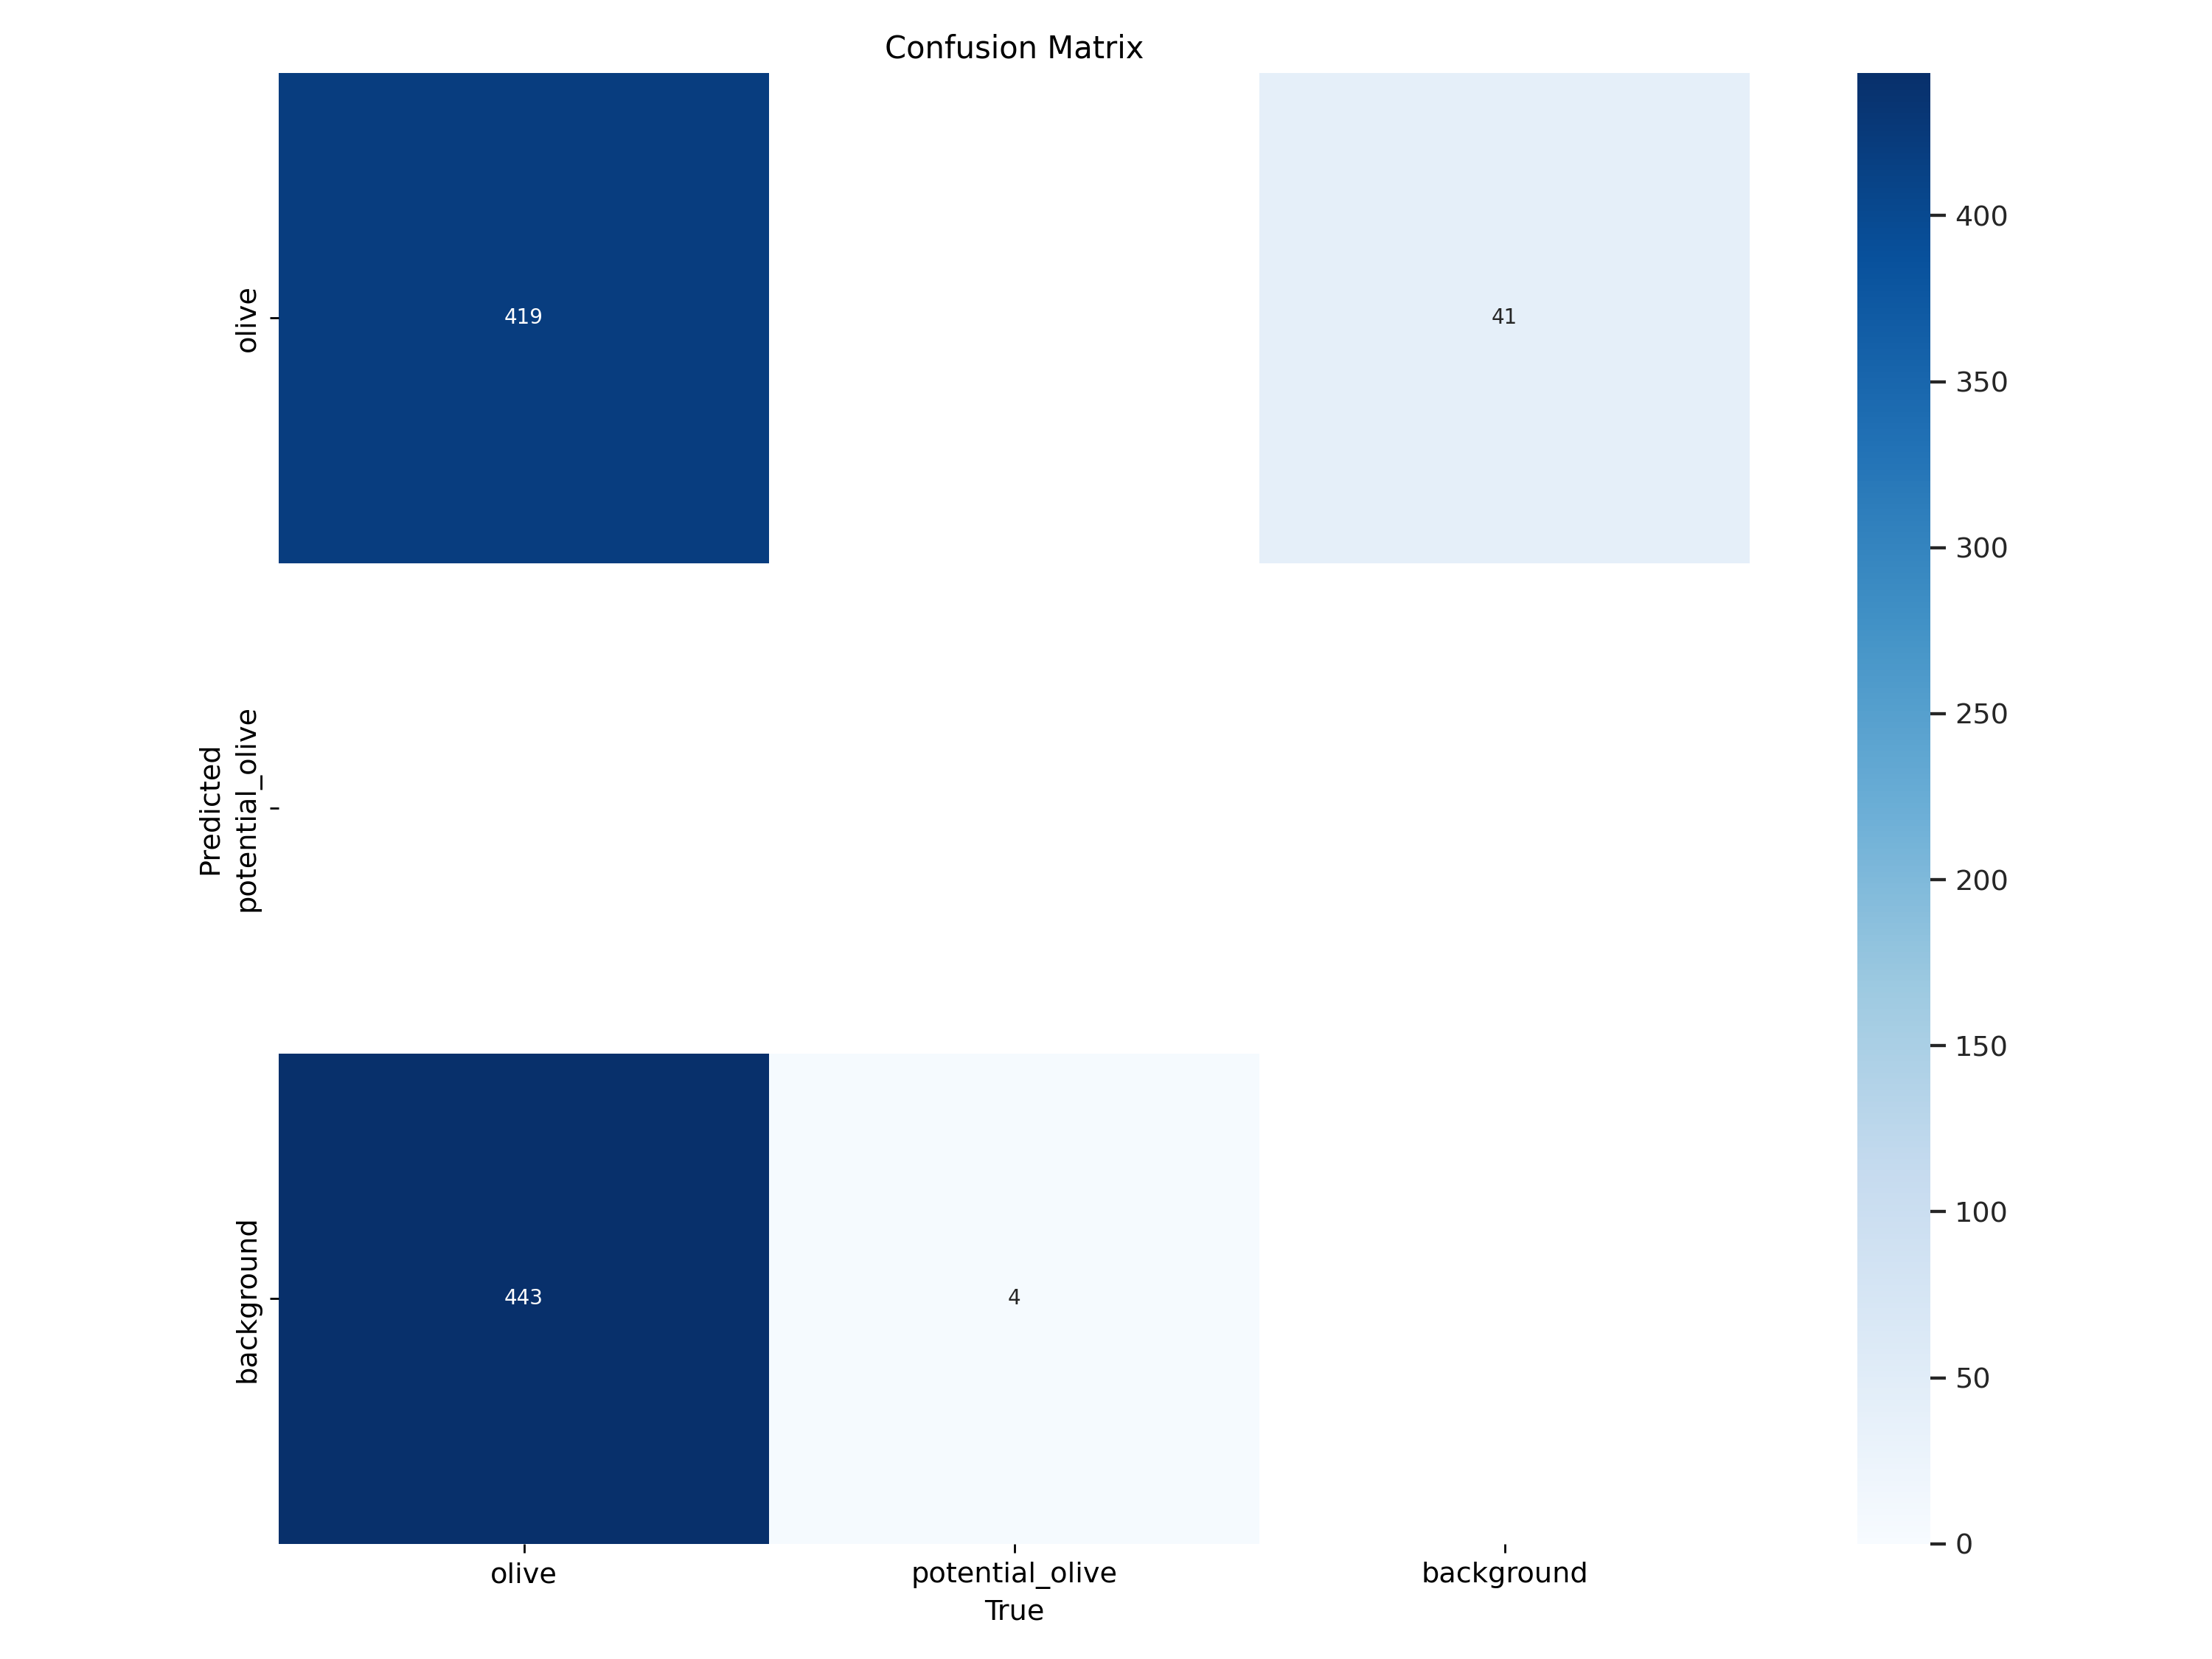

In [ ]:
Image(filename='runs/detect/train4/confusion_matrix.png', width=600)

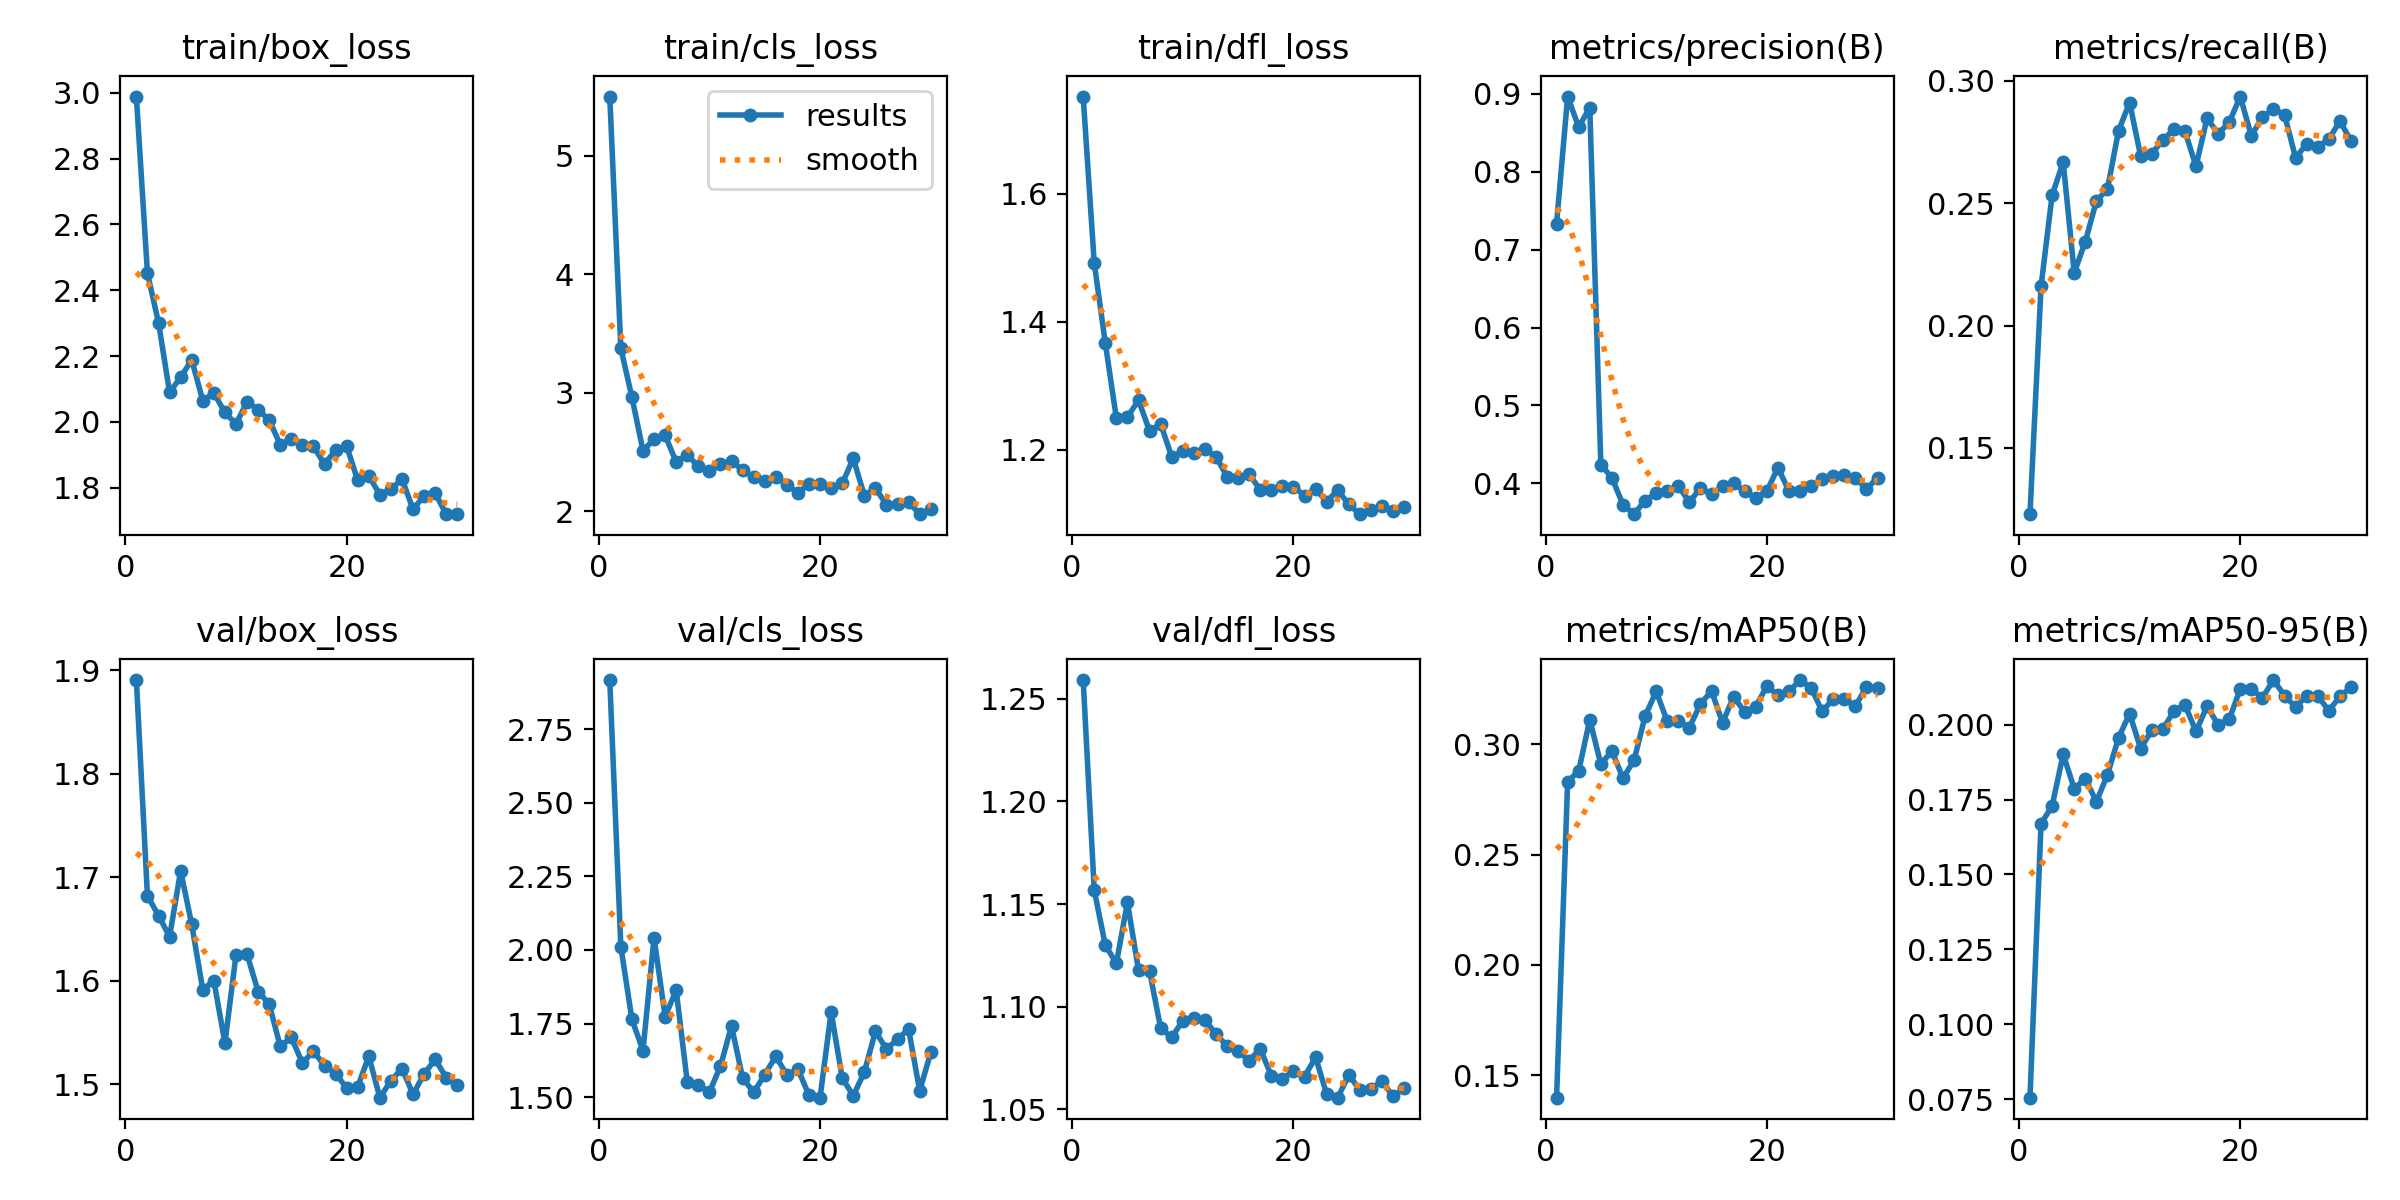

In [ ]:
Image(filename='runs/detect/train4/results.png', width=600)

# Validation

In [ ]:
from ultralytics import YOLO

# Charger le modèle entraîné
model = YOLO("runs/detect/train4/weights/best.pt")

# Évaluer sur le dataset de validation
metrics = model.val(data="/content/split_custom_data_hsv/data.yaml", split="val", verbose=False)

# Accès aux métriques par classe
names = model.names  # dict {class_id: name}
precision_per_class = metrics.box.p  # Précision par classe
recall_per_class = metrics.box.r  # Rappel par classe
map50_per_class = metrics.box.ap50  # mAP à IoU de 0.5 par classe
map_per_class = metrics.box.ap  # mAP à IoU de 0.5-0.95 par classe

# Exemple : récupérer les métriques de la classe "olive"
class_name = "olive"
class_id = list(names.values()).index(class_name)

print(f"Métriques pour la classe '{class_name}':")
print(f" - Précision : {precision_per_class[class_id]:.3f}")
print(f" - Rappel    : {recall_per_class[class_id]:.3f}")
print(f" - mAP@50    : {map50_per_class[class_id]:.3f}")
print(f" - mAP@50-95 : {map_per_class[class_id]:.3f}")


Ultralytics 8.3.134 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 112 layers, 68,125,494 parameters, 0 gradients, 257.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3174.5±971.7 MB/s, size: 228.3 KB)


val: Scanning /content/split_custom_data_hsv/labels/val.cache... 172 images, 109 backgrounds, 0 corrupt: 100%|██████████| 172/172 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:13<00:00,  1.19s/it]


                   all        172        866       0.39      0.288       0.33      0.215
Speed: 1.7ms preprocess, 67.2ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/detect/val
Métriques pour la classe 'olive':
 - Précision : 0.780
 - Rappel    : 0.576
 - mAP@50    : 0.660
 - mAP@50-95 : 0.431


En modifiant conf

In [ ]:
from ultralytics import YOLO
from pathlib import Path
import cv2
import os
from ultralytics.utils.metrics import bbox_iou

# 🔧 Paramètres
model_path = "runs/detect/train4/weights/best.pt"
data_path = "/content/split_custom_data_hsv/data.yaml"
val_images_dir = "/content/split_custom_data_hsv/images/val"
conf_threshold = 0.05  # 🔁 MODIFIE ici le seuil de confiance
target_class = "olive"
iou_threshold = 0.5  # pour comptage TP/FN

# 📦 Charger modèle + noms des classes
model = YOLO(model_path)
names = model.names
target_id = list(names.values()).index(target_class)

# 📂 Liste des fichiers image de validation
image_paths = list(Path(val_images_dir).rglob("*.jpg")) + list(Path(val_images_dir).rglob("*.png"))

# 🔢 Compteurs
TP, FP, FN = 0, 0, 0

# 🔍 Parcourir les images
import torch

# 🔍 Parcourir les images
for img_path in image_paths:
    results = model.predict(source=str(img_path), conf=conf_threshold, iou=iou_threshold, verbose=False)[0]

    # Prédictions pour la classe cible
    preds = [b for b in results.boxes.data.cpu().numpy() if int(b[5]) == target_id]
    pred_boxes = [b[:4] for b in preds]  # x1, y1, x2, y2

    # Ground truth : via les annotations val
    label_path = str(img_path).replace("/images/", "/labels/").rsplit(".", 1)[0] + ".txt"
    gt_boxes = []
    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            for line in f:
                cls, x, y, w, h = map(float, line.strip().split())
                if int(cls) == target_id:
                    # YOLO format -> (x1, y1, x2, y2)
                    img = cv2.imread(str(img_path))
                    H, W = img.shape[:2]
                    cx, cy, bw, bh = x * W, y * H, w * W, h * H
                    x1 = cx - bw / 2
                    y1 = cy - bh / 2
                    x2 = cx + bw / 2
                    y2 = cy + bh / 2
                    gt_boxes.append([x1, y1, x2, y2])

    # 🧠 Matching GT ↔ prédictions
    matched_gt = set()
    for pred_box in pred_boxes:
        matched = False
        for i, gt_box in enumerate(gt_boxes):
            # Convertir en tensor avant de calculer l'IoU
            pred_box_tensor = torch.tensor(pred_box).unsqueeze(0)  # Convertir en tensor
            gt_box_tensor = torch.tensor(gt_box).unsqueeze(0)  # Convertir en tensor
            iou = bbox_iou(pred_box_tensor, gt_box_tensor)[0]  # Calcul de l'IoU
            if iou > iou_threshold and i not in matched_gt:
                TP += 1
                matched_gt.add(i)
                matched = True
                break
        if not matched:
            FP += 1
    FN += len(gt_boxes) - len(matched_gt)

# 📊 Calcul des métriques
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0

print(f"\n🔎 Résultats pour la classe '{target_class}' (seuil conf = {conf_threshold}):")
print(f" - Vrais positifs (TP) : {TP}")
print(f" - Faux positifs (FP)  : {FP}")
print(f" - Faux négatifs (FN)  : {FN}")
print(f" - Précision           : {precision:.3f}")
print(f" - Rappel              : {recall:.3f}")




🔎 Résultats pour la classe 'olive' (seuil conf = 0.05):
 - Vrais positifs (TP) : 630
 - Faux positifs (FP)  : 232
 - Faux négatifs (FN)  : 232
 - Précision           : 0.731
 - Rappel              : 0.731


# Predict

- Vérifie les prédictions avec conf=0.5 ou plus bas : Parfois, si le modèle est trop conservateur, il ne détecte rien parce qu'il exige une très forte confiance. Essaie de réduire le seuil de confiance lors de la prédiction.

In [ ]:
!yolo task=detect mode=predict model=runs/detect/train/weights/best.pt source={base_split_path}/images/val conf=0.5 save=True device=0

Ultralytics 8.3.107 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11x summary (fused): 190 layers, 56,829,334 parameters, 0 gradients, 194.4 GFLOPs

image 1/7 /content/custom_data/images/val/20221108_112521.jpg: 640x288 1 olive, 68.5ms
image 2/7 /content/custom_data/images/val/B18.jpg: 640x288 5 olives, 40.0ms
image 3/7 /content/custom_data/images/val/B2.1.jpg: 640x288 5 olives, 39.9ms
image 4/7 /content/custom_data/images/val/B2.13.jpg: 640x288 16 olives, 40.0ms
image 5/7 /content/custom_data/images/val/IMG_20221123_154057.jpg: 640x480 71 olives, 56.6ms
image 6/7 /content/custom_data/images/val/IMG_20231104_105335.jpg: 480x640 20 olives, 56.5ms
image 7/7 /content/custom_data/images/val/IMG_20231108_122534.jpg: 640x480 50 olives, 69.9ms
Speed: 2.4ms preprocess, 53.0ms inference, 49.1ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs/detect/predict
💡 Learn more at https://docs.ultralytics.com/modes/predict


# VIsualisation

In [ ]:
from IPython.display import Image, display
import glob

predictions = glob.glob('/content/runs/detect/predict/*.jpg')
for image_path in predictions[:10]:
    display(Image(filename=image_path, width=600))

# Télécharger le modèle

In [ ]:
# Create "my_model" folder to store model weights and train results
!mkdir /content/my_model
!cp /content/runs/detect/train2/weights/best.pt /content/my_model/my_model.pt
!cp -r /content/runs/detect/train2 /content/my_model

# Zip into "my_model.zip"
%cd my_model
!zip /content/my_model.zip my_model.pt
!zip -r /content/my_model.zip train2
%cd /content

/content/my_model
  adding: my_model.pt (deflated 8%)
  adding: train2/ (stored 0%)
  adding: train2/train_batch0.jpg (deflated 3%)
  adding: train2/weights/ (stored 0%)
  adding: train2/weights/best.pt (deflated 8%)
  adding: train2/weights/last.pt (deflated 8%)
  adding: train2/val_batch0_pred.jpg (deflated 4%)
  adding: train2/confusion_matrix.png (deflated 37%)
  adding: train2/R_curve.png (deflated 16%)
  adding: train2/results.png (deflated 7%)
  adding: train2/val_batch0_labels.jpg (deflated 4%)
  adding: train2/results.csv (deflated 60%)
  adding: train2/train_batch1.jpg (deflated 2%)
  adding: train2/labels.jpg (deflated 25%)
  adding: train2/args.yaml (deflated 51%)
  adding: train2/train_batch2.jpg (deflated 0%)
  adding: train2/PR_curve.png (deflated 22%)
  adding: train2/labels_correlogram.jpg (deflated 35%)
  adding: train2/F1_curve.png (deflated 16%)
  adding: train2/confusion_matrix_normalized.png (deflated 35%)
  adding: train2/val_batch1_pred.jpg (deflated 5%)
  addin